In [112]:
import pandas
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

from scipy import linalg as LA


In [120]:
def assign_and_preprocess_jets(jets,numpointstot = 1000,unflatten=True,flattenpoints=True):
    if flattenpoints:
        pointslist = np.empty((len(jets),numpointstot*2))
    else:
        pointslist = np.empty((len(jets),numpointstot,2))
    for i, jet in enumerate(jets):
        if unflatten:
            jet = jet[:800].reshape(200,4)
            jet = jet[np.all(jet != 0, axis=1)]
        jet = preprocess_jet(jet)

        if flattenpoints:
            pointslist[i] = assignpoints(jet,numpointstot).flatten()
        else:
            pointslist[i] = assignpoints(jet,numpointstot)
        
    return pointslist

def center_rotate_jet(jet):

    jetsum = np.sum(jet,axis=0)

    beta = jetsum[3]/jetsum[0]
    gamma = 1/(1 - beta**2)**0.5
    longboostmat = np.array([[gamma, 0, 0, -gamma*beta],
                             [0,1,0,0],
                             [0,0,1,0],
                             [-gamma*beta,0,0,gamma]])
    pt = np.linalg.norm(jetsum[1:3])
    stheta = jetsum[2]/pt
    ctheta = jetsum[1]/pt
    rotmat = np.array([[1,0,0,0],
                       [0,ctheta,stheta,0],
                       [0,-stheta,ctheta,0],
                       [0,0,0,1]])

    jet = np.matmul(rotmat,np.matmul(longboostmat,jet.T)).T

    return jet

def preprocess_jet(jet):

    jetsum = np.sum(jet,axis=0)

    beta = jetsum[3]/jetsum[0]
    gamma = 1/(1 - beta**2)**0.5
    longboostmat = np.array([[gamma, 0, 0, -gamma*beta],
                             [0,1,0,0],
                             [0,0,1,0],
                             [-gamma*beta,0,0,gamma]])
    pt = np.linalg.norm(jetsum[1:3])
    stheta = jetsum[2]/pt
    ctheta = jetsum[1]/pt
    rotmat = np.array([[1,0,0,0],
                       [0,ctheta,stheta,0],
                       [0,-stheta,ctheta,0],
                       [0,0,0,1]])

    jet = np.matmul(rotmat,np.matmul(longboostmat,jet.T)).T

    phi = np.arctan2(jet[:,2],jet[:,1])
    eta = 0.5*np.log((jet[:,0]+jet[:,3])/(jet[:,0]-jet[:,3]))
    jet[:,2] = phi
    jet[:,3] = eta
    
    if len(jet) == 1:
        return jet

#     pca = PCA()
#     myfit = pca.fit(jet[:,2:])
#     extrarotate = np.matrix([[0, -1], [1, 0]])

#     principal_rotate = np.diag(np.ones(4))
#     principal_rotate[2:,2:] = np.dot(extrarotate,pca.components_)
#    jet = np.matmul(principal_rotate,jet.T).T


    cov = np.cov(jet[:,2:].T,aweights=jet[:,0])
    evals , evecs = LA.eigh(cov)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    extrarotate = np.matrix([[0, -1], [1, 0]])

    jet[:,2:]=np.dot(np.dot(jet[:,2:], evecs),extrarotate)




    quadrants = np.array([(jet[:,3]>0)*(jet[:,2]>0),
                          (jet[:,3]>0)*(jet[:,2]<0),
                          (jet[:,3]<0)*(jet[:,2]<0),
                          (jet[:,3]<0)*(jet[:,2]>0)])
    
    maxquadrant = np.argmax([np.sum(jet[quadrant,0]) for quadrant in quadrants])
    
    if maxquadrant >= 2:
        jet[:,3] = - jet[:,3]
    if maxquadrant > 0 and maxquadrant < 3:
        jet[:,2] = - jet[:,2]
        
    return jet

def assignpoints(jet,numpointstot = 1000):
    Ejet = np.sum(jet[:,0])
    numpointslist = np.floor_divide(jet[:,0],Ejet/numpointstot)
    numassigned = int(np.sum(numpointslist))
    
    if numassigned < numpointstot:
        remainders = np.remainder(jet[:,0],Ejet/numpointstot)

        extra_args = np.argsort(remainders)[-(numpointstot-numassigned):]
        numpointslist[extra_args] = numpointslist[extra_args]+1

    pointsarray = np.zeros((0,2))
    for i, particle in enumerate(jet):
        newpoints = np.ones((int(numpointslist[i]),2))
        newpoints[:,0] = newpoints[:,0]*particle[2]
        newpoints[:,1] = newpoints[:,1]*particle[3]
        pointsarray = np.append(pointsarray,newpoints,axis=0)
        
    return pointsarray

In [114]:
numpointstot = 1000
columns = np.array([])
for i in range(numpointstot):
    columns = np.append(columns,str(i) + 'x')
    columns = np.append(columns,str(i) + 'y')

In [115]:
import time

input_filename = "/data1/users/jcollins/Heidelberg_sample/train.h5"
store = pandas.HDFStore(input_filename,mode='r')

numpointstot = 1000
columns = np.array([])
for i in range(numpointstot):
    columns = np.append(columns,str(i) + 'x')
    columns = np.append(columns,str(i) + 'y')

#outstore = pandas.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points.h5")

In [116]:
chunk = store.select("table",iterator=False,start=0,stop=1000)
chunk = chunk.loc[chunk['is_signal_new'] == 0]

(array([108., 228., 122.,  56.,  21.,   5.,   0.,   0.,   0.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450]),
 <a list of 9 Patch objects>)

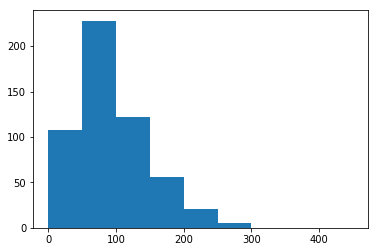

In [117]:
def getmass_jets(jets,numpointstot = 1000,unflatten=True,flattenpoints=True):

    jetsums = np.zeros([0,4])
    for i, jet in enumerate(jets):
        if unflatten:
            jet = jet[:800].reshape(200,4)
            jet = jet[np.all(jet != 0, axis=1)]
        jet = center_rotate_jet(jet)
        jetsums = np.append(jetsums, np.array([np.sum(jet,axis=0)]),axis=0)

    jet_ms = np.sqrt(np.power(jetsums[:,0],2)-np.power(jetsums[:,1],2)-np.power(jetsums[:,2],2)-np.power(jetsums[:,3],2))
        
    return jet_ms
import matplotlib.pyplot as plt
plt.hist(getmass_jets(chunk.values),bins=np.arange(0,500,50))    

(array([104., 228., 123.,  55.,  24.,   6.,   0.,   0.,   0.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450]),
 <a list of 9 Patch objects>)

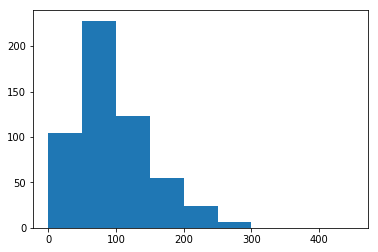

In [110]:
def getmass_jets(jets,numpointstot = 1000,unflatten=True,flattenpoints=True):

    jetmasses = np.zeros([0])
    for i, jet in enumerate(jets):
        if unflatten:
            jet = jet[:800].reshape(200,4)
            jet = jet[np.all(jet != 0, axis=1)]
        jet = center_rotate_jet(jet)
        
        phi = np.arctan2(jet[:,2],jet[:,1])
        eta = 0.5*np.log((jet[:,0]+jet[:,3])/(jet[:,0]-jet[:,3]))
        jet[:,2] = phi
        jet[:,3] = eta
        
        p_parr = np.sum(jet[:,0]*np.cos(jet[:,2])*np.cos(jet[:,3]))
        mass = np.sqrt(np.power(np.sum(jet[:,0]),2) - np.power(p_parr,2))
        jetmasses = np.append(jetmasses, mass)
        
        
    return jetmasses
import matplotlib.pyplot as plt
plt.hist(getmass_jets(chunk.values),bins=np.arange(0,500,50))        

In [82]:
njetsums

array([[ 6.18209088e+02,  6.17077017e+02, -3.27377014e-14,
         5.59725877e-14],
       [ 5.58253270e+02,  5.56271305e+02,  6.63358257e-15,
         2.08166817e-14],
       [ 5.54983600e+02,  5.51548764e+02, -2.22044605e-16,
        -1.44481649e-13],
       ...,
       [ 5.72069015e+02,  5.52744357e+02, -8.60422844e-15,
        -2.92821323e-14],
       [ 5.72348558e+02,  5.68947402e+02, -4.57966998e-15,
         3.83020005e-13],
       [ 6.35982849e+02,  6.06127035e+02,  9.38138456e-15,
         2.83106871e-15]])

In [78]:
jetsums

array([], shape=(0, 4), dtype=float64)

In [75]:
np.shape(np.array([np.sum(jet,axis=0)]))

(1, 4)

In [16]:
np.sum(jets,axis=1)

array([-6.13673327e+02,  1.15984299e+03,  1.31371420e+03,  2.25790734e+02,
       -6.10384429e+02,  3.71452085e+03,  2.65142756e+02,  2.37392423e+03,
        7.90984205e+02,  5.98042167e+02, -6.07887816e+02,  1.84816697e+03,
        4.67287860e+01, -3.66008330e+02,  5.27924041e+02,  2.08096162e+03,
       -6.21837663e+02,  1.30836257e+03, -1.98637470e+02,  1.26814072e+01,
        7.44300275e+02, -1.36185878e+02,  6.42018205e+02,  1.04869481e+02,
        4.82108636e+02,  2.08086638e+02,  2.39679311e+02,  9.52522055e+02,
        2.24504460e+03,  7.18051329e+02,  9.04192639e+02, -9.09667102e+01,
        8.56867567e+02,  2.09782211e+03,  1.48649154e+03,  2.46396818e+03,
        1.82255286e+03,  1.57552552e+02,  1.71867591e+03,  1.15572990e+03,
        1.04733709e+03,  1.52997179e+03,  1.77594742e+02, -1.80371791e+02,
        1.20722752e+03, -5.11239194e+02, -5.35723867e+01,  2.19835908e+03,
        1.61158819e+03,  4.54733732e+02, -3.69090392e+02,  1.09383202e+02,
        6.16482707e+02,  

In [9]:
getmass_jets(jets.values)

IndexError: too many indices for array

In [121]:
start = time.time()
int_time= start
#nmax = 500000
nmax = 10**6
chunksize = 1000
outstore = pandas.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points.h5")

jet_iter = store.select("table",iterator=True,chunksize=chunksize)

for i, chunk in enumerate(jet_iter):
    
    if (i*chunksize)%(nmax/100) == 0:
        print i, time.time() - int_time
        int_time= time.time()
#     if i > numchunks:
#         break

    chunk = chunk.loc[chunk['is_signal_new'] == 0]
    if len(chunk.index) == 0:
        continue
    
    pointsarrays = assign_and_preprocess_jets(chunk.values,numpointstot = 1000)
    dictionary = dict(zip(columns, pointsarrays.T))
    out_df = pd.DataFrame(dictionary,columns=columns)
    outstore.append('points',out_df)
    
print time.time()-start

0 0.0118918418884
10 5.41461491585
20 5.59828591347
30 5.80253505707
40 5.87553715706
50 6.74379682541
60 6.34522414207
70 6.33168506622
80 6.98518586159
90 6.90566897392
100 7.68366408348
110 7.45886492729
120 7.80288887024
130 7.64149785042
140 8.47290205956
150 8.33231306076
160 8.38294291496
170 8.9263651371
180 9.05717301369
190 9.13206601143
200 9.54305481911
210 10.0786929131
220 9.66776204109
230 10.2391560078
240 10.6723978519
250 10.674478054
260 10.9161190987
270 6.02455711365
280 5.90914392471
290 5.73664712906
300 5.86969089508
310 6.12363100052
320 6.57347798347
330 6.75506997108
340 6.71751189232
350 6.87487411499
360 7.09265804291
370 7.90681505203
380 7.83888506889
390 7.60338592529
400 8.29473900795
410 8.41940903664
420 8.59331202507
430 8.36072301865
440 9.01712393761
450 9.30025005341
460 9.65452003479
470 9.46544885635
480 10.0407068729
490 10.3890190125
500 10.0774819851
510 10.6663200855
520 10.7179899216
530 6.81037402153
540 5.46102595329
550 5.54463291168
560

In [122]:
start = time.time()
int_time= start
#nmax = 500000
nmax = 10**6
chunksize = 1000
outstore = pandas.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")

jet_iter = store.select("table",iterator=True,chunksize=chunksize)

for i, chunk in enumerate(jet_iter):
    
    if (i*chunksize)%(nmax/100) == 0:
        print i, time.time() - int_time
        int_time= time.time()
#     if i > numchunks:
#         break

    chunk = chunk.loc[chunk['is_signal_new'] == 1]
    if len(chunk.index) == 0:
        continue
    
    pointsarrays = assign_and_preprocess_jets(chunk.values,numpointstot = 1000)
    dictionary = dict(zip(columns, pointsarrays.T))
    out_df = pd.DataFrame(dictionary,columns=columns)
    outstore.append('points',out_df)
    
print time.time()-start

0 0.0117290019989
10 6.14870405197
20 6.25513100624
30 6.3726439476
40 6.62044906616
50 6.65490007401
60 7.07121896744
70 7.46272778511
80 7.20552492142
90 7.63542795181
100 7.84765195847
110 7.90503382683
120 7.98541998863
130 8.69226408005
140 8.58846783638
150 8.80101084709
160 9.08066701889
170 9.050096035
180 9.59905290604
190 9.55990505219
200 9.7061419487
210 10.0676119328
220 10.4682190418
230 10.3207240105
240 10.5914230347
250 10.5232491493
260 10.8143599033
270 7.93916702271
280 6.36685204506
290 6.55795884132
300 6.85033011436
310 7.03611898422
320 6.98574995995
330 7.04491400719
340 7.62572598457
350 7.88732719421
360 7.96064209938
370 7.79247879982
380 8.37631082535
390 8.87872600555
400 8.53007102013
410 8.67815184593
420 9.0158059597
430 9.69621491432
440 9.42775797844
450 10.0582680702
460 9.64025902748
470 10.311631918
480 11.4135949612
490 11.9519879818
500 11.8647170067
510 12.4390289783
520 13.3396639824
530 11.089648962
540 7.93043613434
550 8.01241087914
560 8.30

In [6]:
len(outstore.select("points"))

605477

In [ ]:
for index, row in df.iterrows():
    jet = jets_df.sample().values[0,:800].reshape(200,4)

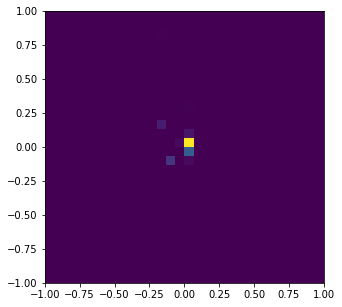

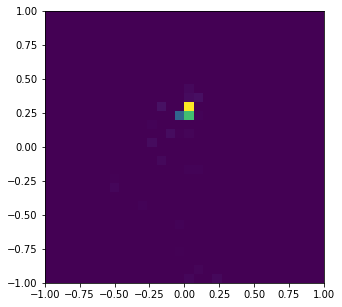

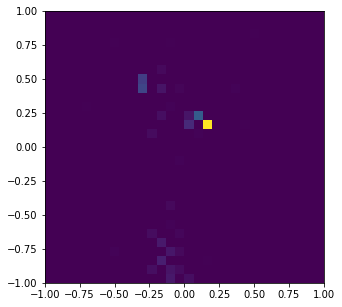

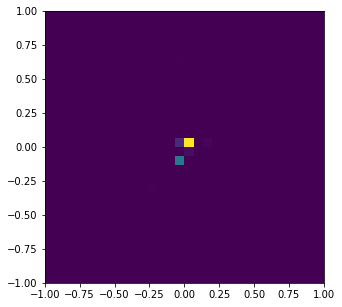

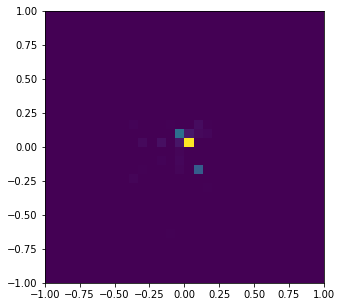

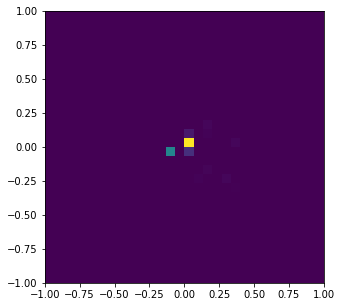

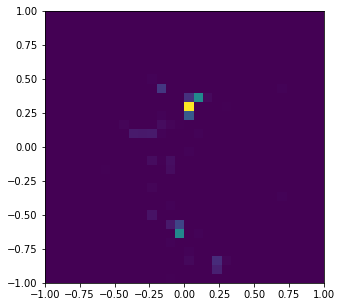

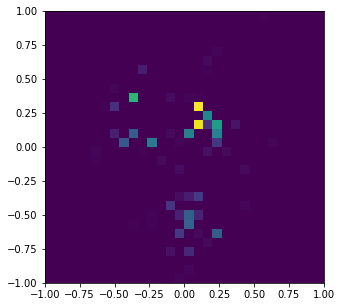

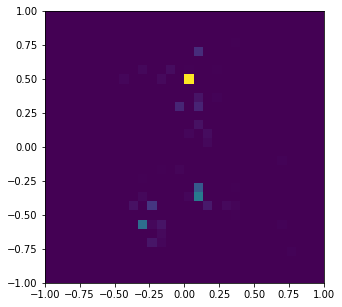

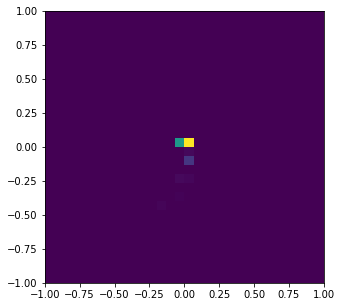

In [311]:
for i in range(10):
    jet = this.sample().values[0,:800].reshape(200,4)
    jet = jet[np.all(jet != 0, axis=1)]
    pointsarray = assignpoints(preprocess_jet(jet))
    lim=1
    plt.figure(figsize=[5,5])
    plt.hist2d(pointsarray[:,0],pointsarray[:,1],range=[[-lim,lim],[-lim,lim]],bins=30)
    plt.show()

In [298]:
pointsarray = assignpoints(jet)

In [ ]:
pointsarray

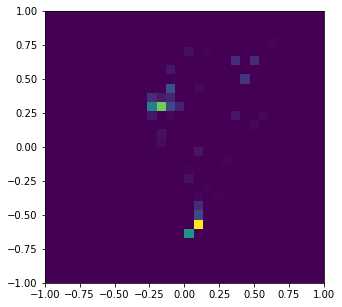

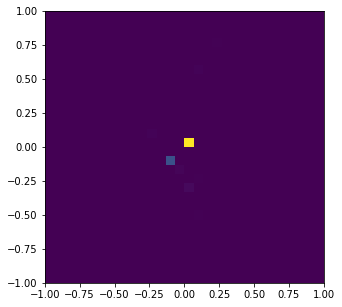

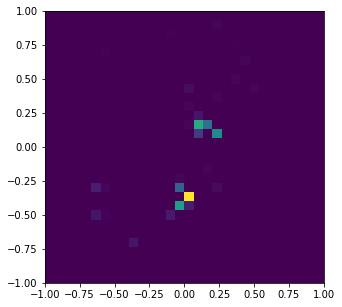

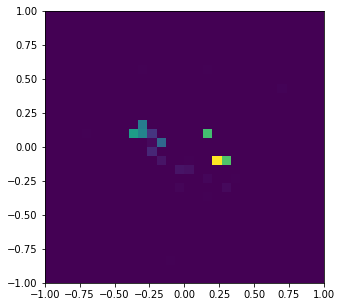

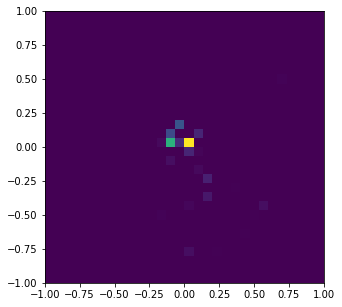

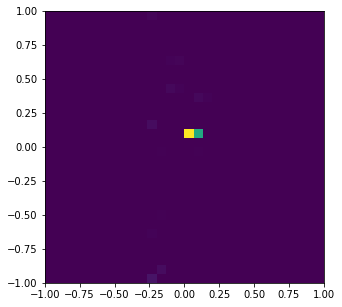

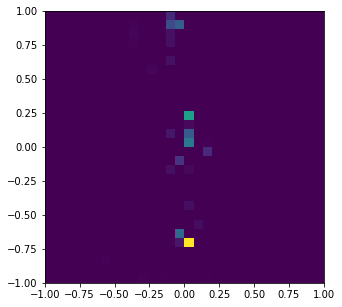

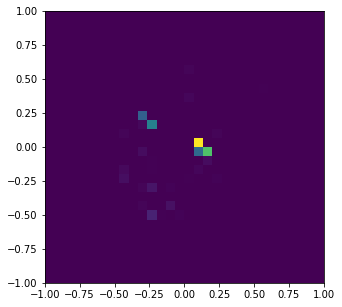

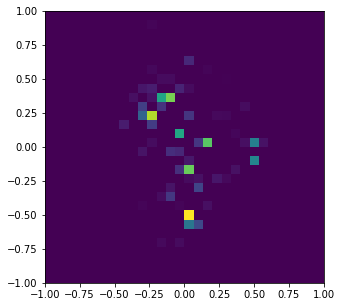

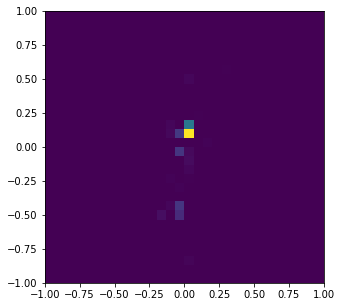

In [304]:
for i in range(10):
    jet = this.sample().values[0,:800].reshape(200,4)
    jet = jet[np.all(jet != 0, axis=1)]
    jet = preprocess_jet(jet)
    lim=1
    plt.figure(figsize=[5,5])
    plt.hist2d(jet[:,2],jet[:,3],weights = jet[:,0],range=[[-lim,lim],[-lim,lim]],bins=30)
    plt.show()

In [96]:
np.sqrt(jetsum[0]**2-np.linalg.norm(jetsum[1:])**2)

136.4436579925801

In [97]:
newjetsum=np.dot(longboostmat,jetsum)
np.sqrt(newjetsum[0]**2-np.linalg.norm(newjetsum[1:])**2)

136.44365799257884

In [98]:
ptlist = np.linalg.norm(row[:,1:3],axis=1)
pabslist = np.linalg.norm(row[:,0,1:],axis=1)
pL = row[:,3]
eta = 0.5*np.log((pabs+pL)/(pabs-pL))

IndexError: too many indices for array

In [34]:
row[0,0]

145.50405883789062

In [77]:
np.arctan2(1.,-1)

2.356194490192345